# **Target Trial Emulation [Version 1]**

- Josef Hasm A. Agunod
- Sharly Pia Rose S. Barago




---





**Target Trial Emulation (TTE)** is a method used to study treatment effects by making observational data look more like a real clinical trial. This helps reduce bias and get more accurate results.  

In this assignment, we’ll use Python to recreate TTE based on existing R code from [this tutorial](https://rpubs.com/alanyang0924/TTE). This first version (**TTE-v1**) focuses on:  

- Getting the dataset.  
- Converting the R code to Python.  
- Running the TTE steps and checking the results.  

This will prepare us for **TTE-v2**, where we’ll add clustering methods.  



---



# **Data Preparation**

## **Extracting the Dataset**

This step is all about preparing the data package for analysis. We got the data package from the tutorial by following the first few steps for Data Preparation.

## **Load and Prepare the Data in Python**

Here, we start converting the R code into Python for data manipulation. The block of code below is the equivalent Python Code from Alan Yang's R Code in the Data Preparation section.

In [ ]:
!pip install lifelines
import pandas as pd

# Load the dataset
data_censored = pd.read_csv("data_censored.csv")

# View first few rows
print(data_censored.head())

# Convert categorical variables (if needed)
data_censored['treatment'] = data_censored['treatment'].astype(int)
data_censored['outcome'] = data_censored['outcome'].astype(int)
data_censored['eligible'] = data_censored['eligible'].astype(int)

# Display dataset info
print(data_censored.info())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null  

This gives us the same `head(data_censored)` output as in R.

## **Defining the Target Trial Data Structure**

We do this step by storing the trial sequence as a dictionary for later processing.

In [ ]:
# Define trial structure
trial_pp = {
    "data": data_censored,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Check the dataset summary
print(trial_pp["data"].describe())


               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.500173   
min      1.000000    0.000000    0.000000    0.000000   -3.284355    0.000000   
25%     23.000000    2.000000    0.000000    0.000000   -0.809344    0.000000   
50%     50.000000    6.000000    0.000000    0.000000   -0.163060    0.000000   
75%     73.000000   12.000000    1.000000    1.000000    0.494103    1.000000   
max     99.000000   19.000000    1.000000    1.000000    3.907648    1.000000   

               x4         age       age_s     outcome   censored    eligible  
count  725.000000  725.000000  725.000000  725.000000  725.00000  725.000000  
mean    -0.274722   48.093793    1.091149    0.015172    0.08000    0.234483  
std      1.008643   11.834472    

For Intention-To-Treat (ITT) setup, we define:

In [ ]:
trial_itt = trial_pp.copy()

# **Inverse Probability of Censoring Weighting (IPCW)**

This step uses Inverse Probability of Censoring Weights (IPCW) to correct for bias caused by censored data. Without this, our survival analysis could be biased since it would only reflect patients who stayed in the study.

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def calculate_ipcw_weights(data, censor_col, feature_cols):

    """
    Calculate inverse probability of censoring weights (IPCW).

    Parameters:
        - data: DataFrame containing the dataset.
        - censor_col: The column indicating if the observation was censored.
        - feature_cols: List of feature columns to predict censoring.

    Returns:
        - Updated DataFrame with computed IPCW weights.
    """

    # Prepare features (X) and target (y)
    X = data[feature_cols]
    y = 1 - data[censor_col]  # IPCW models censoring as (1 - censored)

    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X, y)

    # Predict probabilities (inverse of censoring probability)
    data["ipcw_weights"] = 1 / model.predict_proba(X)[:, 1]

    return data

# Apply IPCW model for censoring adjustments
feature_columns = ["x2", "x1"]  # Same features as in R example
data_censored = calculate_ipcw_weights(data_censored, "censored", feature_columns)

# Show the first few rows with weights
print(data_censored.head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  ipcw_weights  
0         0         1      1.096741  
1         0         0      1.057148  
2         0         0      1.086812  
3         0         0      1.108750  
4         0         0      1.063058  


# **Expanding Trials for Follow-ups**

This step simulates repeated follow-up periods by duplicating the dataset for each time point by adding a `trial_period` column.

In [ ]:
def expand_trials(data, max_period=10):

    """
    Expands the dataset for each time period.

    Parameters:
        - data: Original DataFrame.
        - max_period: Number of follow-up periods to expand.

    Returns:
        - Expanded DataFrame.
    """

    expanded_data = []

    for period in range(max_period):
        temp_data = data.copy()
        temp_data["trial_period"] = period
        expanded_data.append(temp_data)

    return pd.concat(expanded_data)

# Expand the dataset
expanded_data = expand_trials(data_censored, max_period=10)

# Display the expanded dataset
print(expanded_data.head())


   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  ipcw_weights  trial_period  
0         0         1      1.096741             0  
1         0         0      1.057148             0  
2         0         0      1.086812             0  
3         0         0      1.108750             0  
4         0         0      1.063058             0  


# **Survival Analysis**

Here, we use Cox Proportional Hazards Model for our Survival Analysis. We use this because it flexibly estimates how variables affect the time until an event occurs in addition to it being able to handle censored data.

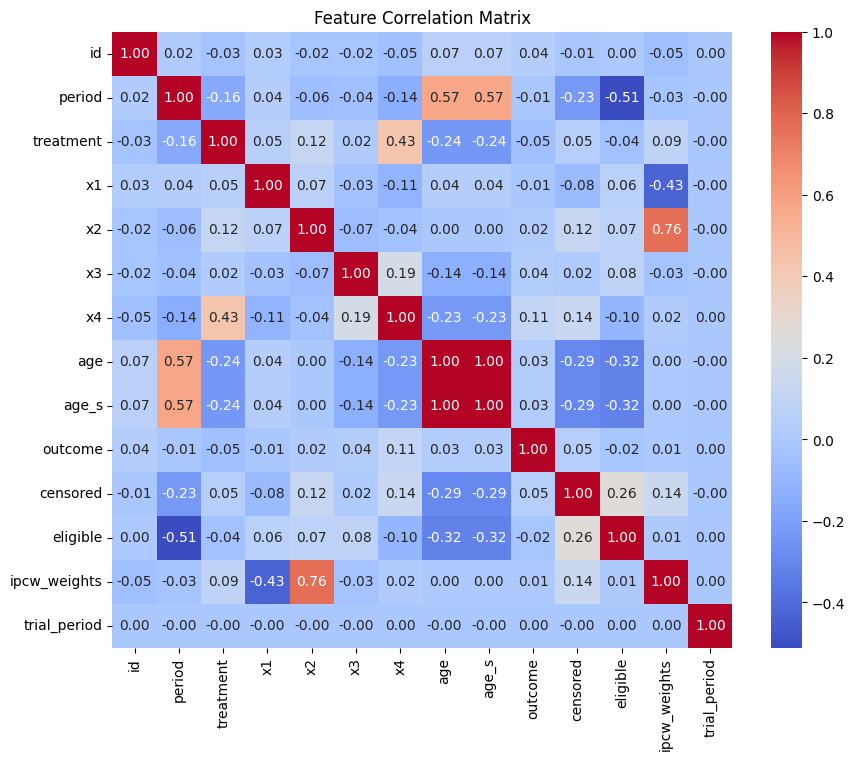

<lifelines.CoxPHFitter: fitted with 7250 total observations, 7140 right-censored observations>
             duration col = 'period'
                event col = 'outcome'
      baseline estimation = breslow
   number of observations = 7250
number of events observed = 110
   partial log-likelihood = -742.31
         time fit was run = 2025-03-09 13:56:28 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
treatment     -2.55      0.08      0.29           -3.12           -1.99                0.04                0.14
x1            -4.54      0.01      0.90           -6.31           -2.77                0.00                0.06
x2             3.75     42.55      0.68            2.42            5.08               11.28              160.50
x3            -0.08      0.93      0.22           -0.52            0.36                0.60                1.44
x4             1.83      6.23      0.14            1.55            2.11                4.69                8.27
age            0.01      1.01      0.01           -0.01            0.03                0.99                1.03
censored       1.55      4.73      0.32            0.92            2.19                2.52                8.89
eligible       1.74      5.69      0.37            1.01            2.46                2.76               11.73
ipcw_weights -75.36      0.00     15.32         -105.39          -45.33                0.00                0.00
trial_period   0.00      1.00      0.03           -0.07            0.07                0.94                1.07

              cmp to     z      p  -log2(p)
covariate                                  
treatment       0.00 -8.90 <0.005     60.65
x1              0.00 -5.04 <0.005     21.04
x2              0.00  5.54 <0.005     24.96
x3              0.00 -0.34   0.74      0.44
x4              0.00 12.65 <0.005    119.44
age             0.00  0.64   0.52      0.93
censored        0.00  4.83 <0.005     19.45
eligible        0.00  4.71 <0.005     18.59
ipcw_weights    0.00 -4.92 <0.005     20.13
trial_period    0.00  0.00   1.00     -0.00
---
Concordance = 0.90
Partial AIC = 1504.62
log-likelihood ratio test = 307.77 on 10 df
-log2(p) of ll-ratio test = 197.49

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter

# Check collinearity among features
correlation_matrix = expanded_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Drop highly correlated features (example: age_s is derived from age)
expanded_data_filtered = expanded_data.drop(columns=["age_s","id"])

# Ensure no zero-variance columns (columns with constant values)
zero_variance_cols = expanded_data_filtered.columns[expanded_data_filtered.nunique() == 1]
expanded_data_filtered = expanded_data_filtered.drop(columns=zero_variance_cols)

# Fit the Cox Model again
cph = CoxPHFitter()
cph.fit(expanded_data_filtered, duration_col="period", event_col="outcome")

# Display model summary
cph.print_summary()